In [53]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [54]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
# Hyper-parameters
VALID_SIZE = 0.1
input_dim = 784     # 28x28
hidden_dim = 500 
output_dim = 10     # number of classes
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Loading MNIST dataset

In [56]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [57]:
# Add Validation data
num_train = len(train_dataset)
indices = list(range(num_train)) # get indices of train
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split] # split data

# define samplers for training and validation batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [58]:
# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size,
    shuffle=False
)

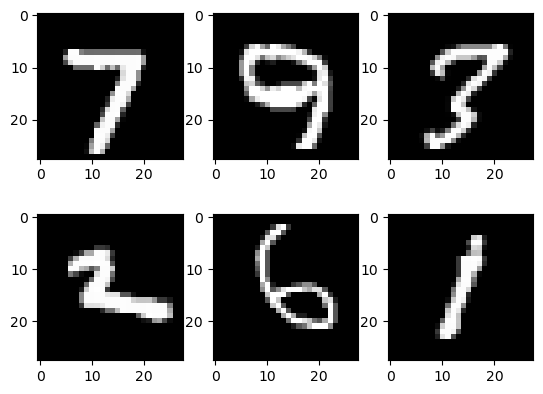

In [59]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [60]:
# Fully connected neural network with one hidden layer
class FeedForwardNeuralNet(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(FeedForwardNeuralNet, self).__init__()
            self.input_size = input_dim
            # Linear function
            self.l1 = nn.Linear(input_dim, hidden_dim) 
            # Non-linearity
            self.tanh = nn.Tanh()
            #Linear function
            self.l2 = nn.Linear(hidden_dim, output_dim)
        
        
        def forward(self, x):
            out = self.l1(x)
            out = self.tanh(out)
            out = self.l2(out)
            # no activation and no softmax at the end
            return out
    
model = FeedForwardNeuralNet(input_dim, hidden_dim, output_dim).to(device)

In [61]:
print(model)

FeedForwardNeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (tanh): Tanh()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)


In [62]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [63]:
# Train the model
n_total_steps = len(train_loader)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training phase
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

            
        if (i + 1) % 100 == 0:
            average_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{n_total_steps}], Loss: {average_loss:.4f}")
            running_loss = 0.0

    train_losses.append(average_loss)
    
            
    # validation phase
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.reshape(-1, 28*28).to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            
    average_valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(average_valid_loss)
    print(f"Valid Epoch [{epoch+1}/{num_epochs}], Loss: {average_valid_loss:.4f}")


Epoch [1/5], Batch [100/540], Loss: 0.0010
Epoch [1/5], Batch [200/540], Loss: 0.0005
Epoch [1/5], Batch [300/540], Loss: 0.0005
Epoch [1/5], Batch [400/540], Loss: 0.0005
Epoch [1/5], Batch [500/540], Loss: 0.0004
Valid Epoch [1/5], Loss: 0.0002
Epoch [2/5], Batch [100/540], Loss: 0.0003
Epoch [2/5], Batch [200/540], Loss: 0.0003
Epoch [2/5], Batch [300/540], Loss: 0.0003
Epoch [2/5], Batch [400/540], Loss: 0.0003
Epoch [2/5], Batch [500/540], Loss: 0.0003
Valid Epoch [2/5], Loss: 0.0001
Epoch [3/5], Batch [100/540], Loss: 0.0002
Epoch [3/5], Batch [200/540], Loss: 0.0002
Epoch [3/5], Batch [300/540], Loss: 0.0002
Epoch [3/5], Batch [400/540], Loss: 0.0002
Epoch [3/5], Batch [500/540], Loss: 0.0002
Valid Epoch [3/5], Loss: 0.0001
Epoch [4/5], Batch [100/540], Loss: 0.0002
Epoch [4/5], Batch [200/540], Loss: 0.0001
Epoch [4/5], Batch [300/540], Loss: 0.0002
Epoch [4/5], Batch [400/540], Loss: 0.0001
Epoch [4/5], Batch [500/540], Loss: 0.0002
Valid Epoch [4/5], Loss: 0.0001
Epoch [5/5],

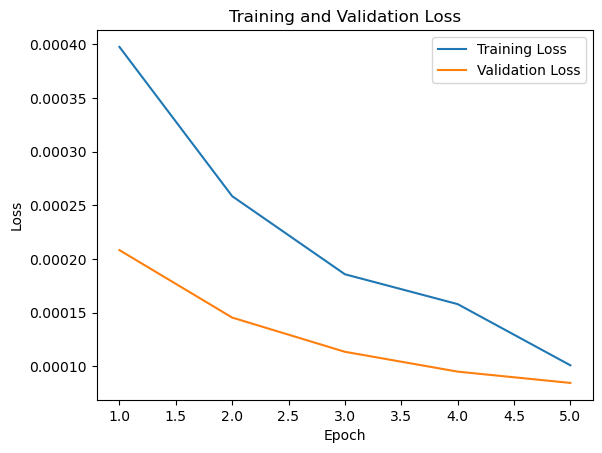

In [64]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [68]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.64 %


In [72]:
len(train_loader.dataset)

60000

In [73]:
len(train_loader)

540

In [74]:
len(valid_loader.dataset)

60000

In [75]:
len(valid_loader)

60